# Classification Analysis — Breast Cancer (Logistic Regression)

## Introduction
This notebook presents a data analysis and logistic regression model applied to the *Breast Cancer Wisconsin (Diagnostic)* dataset. The main goal is to detect malignant and benign tumors from morphological features extracted from fine needle aspiration (FNA) images. The document is written as a professional portfolio piece: explaining what was done, why it was done, and what the results mean for recruiters and technical teams.

## Dataset description
- Source: UCI Machine Learning Repository (Breast Cancer Wisconsin - Diagnostic).
- Observations: each row corresponds to an FNA image of a tumor.
- Target label: `diagnosis` (M = malignant, B = benign, convert to malignant =1, bening = 0).
- Features: 30 numerical features (mean, standard error and worst of 10 morphological measures such as radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry and fractal dimension).

## Project objective
1. Perform Exploratory Data Analysis (EDA) to understand distributions and relationships among morphological variables.
2. Build and evaluate a logistic regression classifier.
3. Focus on **reducing false negatives** (cases where the model labels a malignant tumor as benign), prioritizing clinical safety.

## Methodology (summary)
1. Data loading and cleaning.
2. Exploratory analysis (descriptive statistics, visualizations and correlations).
3. Train-test split.
4. Train a logistic regression model.
5. Evaluate using key metrics: confusion matrix, precision, recall (sensitivity), specificity and AUC-ROC. Special attention is given to the malignant class recall.
6. Shift the classification threshold towards higher sensitivity.

## Key results (summary)
- A logistic regression model was trained and evaluated on the test set.
- A trade-off between precision and sensitivity was observed; reducing false negatives typically comes at the cost of specificity.
- Detailed metrics and ROC curves are available in the results section of the notebook.

---

## Índice de contenido

1. [Data](#1-data)
2. [Data Cleaning](#2data-cleaning)
3. [Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
4. [Model ML](#4-model-ml)
5. [Threshold Analysis](#5-threshold-analysis)
6. [Model with custom Threshold](#6-model-with-custom-threshold)
7. [Analysis Conclusions](#7-analysis-conclusions)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')
from scipy import stats

# 1. Data

In [2]:

path = r'C:\Users\Ernes\OneDrive\Documents\Modelos ML\Data\BreastCancer.csv'
df = pd.read_csv(path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# 2. Data Cleaning

## NaN Values

In [3]:
#we removed the unnecessary column
df.drop(columns=['id','Unnamed: 32'],inplace=True)
#the id column is not useful for the analysis.
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


## Duplicated values

In [4]:
df.duplicated().any()

False

## Convert Data

In [5]:
# Re-encoded target variable: 'M' (malignant) → 1, 'B' (benign) → 0
# This binary format aligns with our objective of detecting breast cancer presence
df['diagnosis'].replace({'M':1,'B':0},inplace=True)

## Data optimization

It is recommended to optimize once the dataset exceeds 100,000 rows, we will apply this for practice purposes.

In [6]:
# initial memory usage before optimization or data transformation
df.memory_usage(deep=True)


Index                       132
diagnosis                  4552
radius_mean                4552
texture_mean               4552
perimeter_mean             4552
area_mean                  4552
smoothness_mean            4552
compactness_mean           4552
concavity_mean             4552
concave points_mean        4552
symmetry_mean              4552
fractal_dimension_mean     4552
radius_se                  4552
texture_se                 4552
perimeter_se               4552
area_se                    4552
smoothness_se              4552
compactness_se             4552
concavity_se               4552
concave points_se          4552
symmetry_se                4552
fractal_dimension_se       4552
radius_worst               4552
texture_worst              4552
perimeter_worst            4552
area_worst                 4552
smoothness_worst           4552
compactness_worst          4552
concavity_worst            4552
concave points_worst       4552
symmetry_worst             4552
fractal_

In [7]:
dtype_dict = {df.columns[0]: 'uint8'}  # binary 0,1
dtype_dict.update({col: 'float32' for col in df.columns[1:]}) # Converted remaining columns to float32 to reduce memory usage and improve performance
df = df.astype(dtype_dict)

In [8]:
# final memory usage
df.memory_usage(deep=True)

Index                       132
diagnosis                   569
radius_mean                2276
texture_mean               2276
perimeter_mean             2276
area_mean                  2276
smoothness_mean            2276
compactness_mean           2276
concavity_mean             2276
concave points_mean        2276
symmetry_mean              2276
fractal_dimension_mean     2276
radius_se                  2276
texture_se                 2276
perimeter_se               2276
area_se                    2276
smoothness_se              2276
compactness_se             2276
concavity_se               2276
concave points_se          2276
symmetry_se                2276
fractal_dimension_se       2276
radius_worst               2276
texture_worst              2276
perimeter_worst            2276
area_worst                 2276
smoothness_worst           2276
compactness_worst          2276
concavity_worst            2276
concave points_worst       2276
symmetry_worst             2276
fractal_

# 3. Exploratory Data Analysis (EDA)
In this section, morphological variables are explored using descriptive statistics, histograms, scatter plots, and correlation matrices. The goal is to understand the data distribution and identify potential relationships between features.

## Percentage Between Groups

In [9]:
df['diagnosis'].value_counts(normalize=True) * 100 

0    62.741652
1    37.258348
Name: diagnosis, dtype: float64

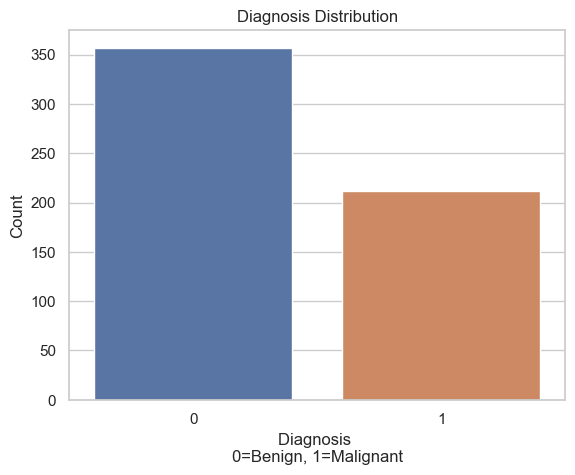

In [10]:
sns.countplot(x='diagnosis',data=df)
plt.title('Diagnosis Distribution')
plt.xlabel('Diagnosis \n0=Benign, 1=Malignant')
plt.ylabel('Count')
plt.show()

In [11]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289650,91.969032,654.889038,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269192,25.677223,107.261215,880.583130,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524048,4.301038,24.298983,351.914093,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833241,6.146256,33.602535,569.356873,0.022832,0.157337,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790001,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.199997,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.169998,420.299988,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110001,515.299988,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.239998,551.099976,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660004,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.799999,104.099998,782.700012,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790001,29.719999,125.400002,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110001,39.279999,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040001,49.540001,251.199997,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Correlation with the Target Variable

In [12]:

corr_matrix = df.corr(numeric_only=True)
corr_matrix['diagnosis'].sort_values(ascending=False)


diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

Since these are morphological variables, we will treat all columns as our independent variables.

## Frequency Plots for Selected Morphological Variables

In [13]:
def plotFrecuencias(variable):
    hist_malignant = plt.hist(df[df["diagnosis"] == 1][variable],bins=30,fc = (1,0,0,0.5),label = 'Malignant')
    hist_benign = plt.hist(df[df["diagnosis"] == 0][variable],bins=30,fc = (0,1,0,0.5),label = 'Benign')
    plt.legend()
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f'Histogram of  {variable} Bening and Malignant Tumors')
    plt.show()

    frequent = hist_malignant[0].max()
    index_frequent = list(hist_malignant[0]).index(frequent)
    most_frequent_malignant = hist_malignant[1][index_frequent]

    print(f'Most frequent {variable} is: {most_frequent_malignant}')

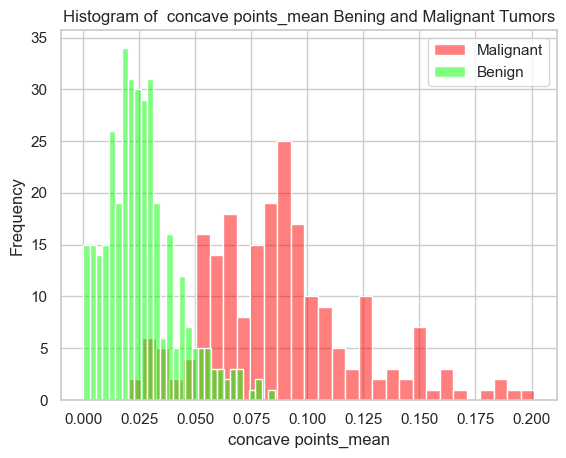

Most frequent concave points_mean is: 0.08663632720708847


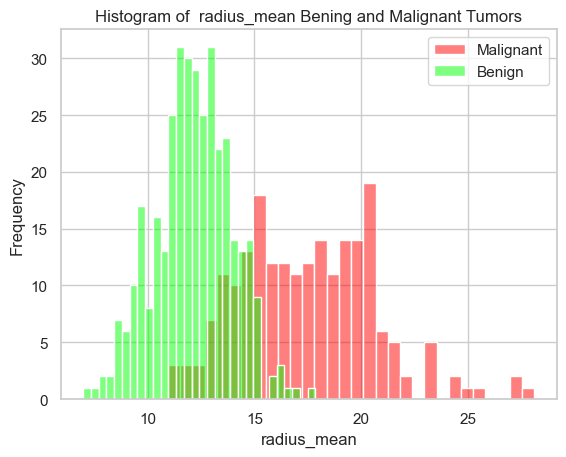

Most frequent radius_mean is: 20.102001190185547


In [14]:
vars = ['concave points_mean','radius_mean']
for var in vars:
    plotFrecuencias(var)

We can observe the following:

- Patients with malignant tumors tend to have, on average, a higher number of concavities along the edges of the nucleus, indicating more irregular borders.

- The nuclear radius in patients with malignant tumors also tends to be larger.

## Relationship Between Radius and Concavity

<Axes: xlabel='radius_mean', ylabel='concave points_mean'>

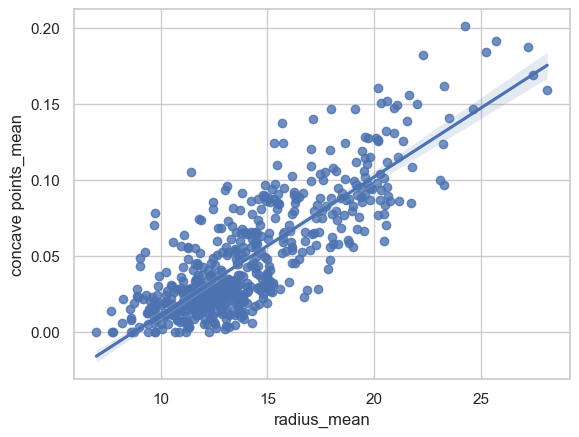

In [15]:
sns.regplot(x=df['radius_mean'],y=df['concave points_mean'],data=df)

In [16]:
df[['radius_mean', 'concave points_mean']].corr(method='pearson').iloc[1]

radius_mean            0.822529
concave points_mean    1.000000
Name: concave points_mean, dtype: float64

There is a strong correlation ($r=0.82$) between the variables `'radius_mean'` and `'concave points_mean'`

## Cohen’s Effect Size

In [17]:
df_malignant = df[df['diagnosis'] == 1].copy()
df_benign = df[df['diagnosis'] == 0].copy()

In [18]:
def cohen(var):
    mean_diff = df_malignant[var].mean() - df_benign[var].mean()
    var_bening = df_benign[var].var()
    var_malignant = df_malignant[var].var()

    s = (len(df_benign)*var_bening + len(df_malignant)*var_malignant ) / float(len(df_benign)+ len(df_malignant))
    d = mean_diff/np.sqrt(s)

    print(f'Effect size of {var}: {d}')

In [19]:
cohen('concave points_mean')
cohen('radius_mean')

Effect size of concave points_mean: 2.544337418091669
Effect size of radius_mean: 2.204858743482107


This means that the probability of a person with a malignant tumor having higher values in the variables `'radius_mean'` and `'concave points_mean'` is approximately $95\%$.

# 4. Model ML

## Logistic Regression Modeling  
A logistic regression model is trained using the training set and evaluated with the test set. Key metrics such as accuracy, recall, and AUC-ROC are analyzed.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    recall_score,
    precision_score,
    f1_score
)

In [21]:
# Variables
X = df.drop(columns='diagnosis').copy() #Features
y = df['diagnosis'].copy() #Target

In [22]:
#split Train-Test Sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

model = LogisticRegression(solver='liblinear')
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [23]:
#prediction
y_pred = model.predict(X_test)

#Prediction Probability
y_pred_prob = model.predict_proba(X_test)

## Results and Evaluation  
The model results are presented, including the confusion matrix and the ROC curve. The impact of false negatives is discussed, along with how adjusting the threshold can influence the model’s sensitivity.

In [24]:
def plot_model_evaluation(y_test, y_pred, y_pred_prob, model_name="Model"):
   """
 Generate model evaluation plots: Confusion Matrix and ROC Curve

Parameters:  
- `y_test`: actual values  
- `y_pred`: model predictions  
- `y_pred_prob`: predicted probabilities  
- `model_name`: model name for plot titles
   """
   
   # Crear subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
   
   # 1. Matriz de Confusión
   cm = confusion_matrix(y_test, y_pred)
   sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax1)
   ax1.set_title(f"{model_name} Confusion Matrix")
   ax1.set_xlabel("Predicted")
   ax1.set_ylabel("Actual")
    
   # 2. Curva ROC
   if y_pred_prob.ndim > 1:  # Si tiene múltiples columnas
       y_prob = y_pred_prob[:, 1]
   else:  # Si es un array 1D
       y_prob = y_pred_prob
   
   fpr, tpr, thresholds = roc_curve(y_test, y_prob)
   roc_auc = auc(fpr, tpr)
   
   ax2.plot(fpr, tpr, label=f'{model_name} ROC (AUC = {roc_auc:.4f})', color='green')
   ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
   ax2.set_xlabel('False Positive Rate')
   ax2.set_ylabel('True Positive Rate')
   ax2.set_title(f'ROC Curve - {model_name}')
   ax2.legend(loc="lower right")
   ax2.grid(True, alpha=0.3)
   
   plt.tight_layout()
   plt.show()
   
   # Mostrar métricas adicionales
   print(f"\n Métricas de {model_name}:")
   print(f"AUC Score: {roc_auc:.4f}")
   print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
   print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# Function usage:
# plot_model_evaluation(y_test, y_pred, y_pred_prob, "Logistic Regression")

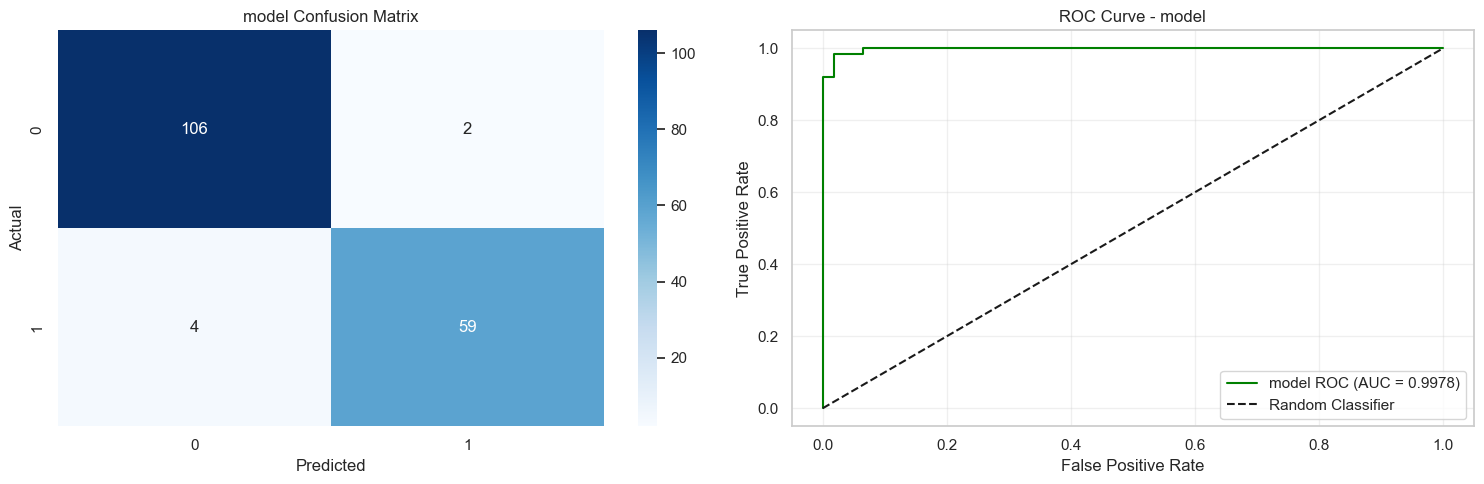


 Métricas de model:
AUC Score: 0.9978
Accuracy: 0.9649
F1-Score: 0.9516


In [25]:
plot_model_evaluation(y_test, y_pred, y_pred_prob, model_name="model")

In [26]:
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

Recall: 0.9365079365079365


We have an acceptable F1-Score of $0.95$; however, our focus is on reducing false negatives. To achieve this, we will analyze an optimal threshold.

# 5. Threshold Analysis  
We will analyze the optimal threshold to achieve the best possible F1 score, focusing on values between 0.7 and 0.9.

In [27]:
def prob_labels(predict_prob, umbral = 0.5):
    predic = np.zeros([len(predict_prob), ]) #array zeros
    predic[predict_prob[:,1]>= umbral] = 1   #Umbral config
    return predic

In [28]:
def evaluate_umbral(umbral):
    #Metrics
    predict_umbral = prob_labels(y_pred_prob,umbral)
    precision_umbral = precision_score(y_test, predict_umbral)
    recall_umbral = recall_score(y_test, predict_umbral)
    F1_umbral = f1_score(y_test, predict_umbral)

    return (umbral,precision_umbral,recall_umbral,F1_umbral)

In [29]:
umbrales = np.linspace(0.,1.,1000) # 1000 umbrales  0 to 1

In [30]:
evaluation = pd.DataFrame([evaluate_umbral(x) for x in umbrales],
                            columns=['umbral','precision','recall','F1'])

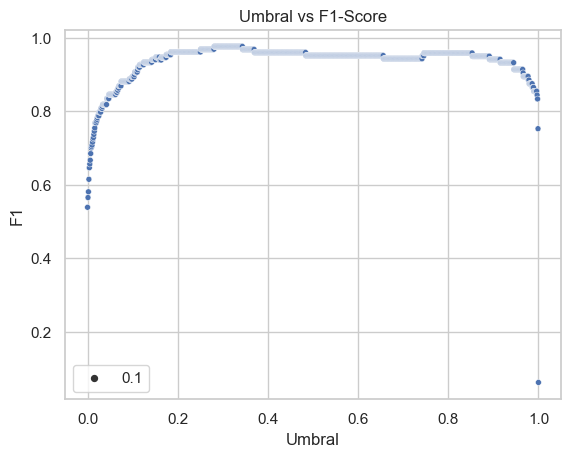

In [31]:
## Plot umbral
sns.scatterplot(x='umbral', y='F1', data=evaluation, marker="o",size=0.1)
plt.title('Umbral vs F1-Score')
plt.xlabel("Umbral")
plt.ylabel("F1")
plt.show()

In [32]:
fila_max_f1 = evaluation.loc[evaluation['F1'].idxmax()]
print(fila_max_f1)

umbral       0.281281
precision    0.968750
recall       0.984127
F1           0.976378
Name: 281, dtype: float64


With a threshold of 0.281281, an increase of 2% in the F1 score is achieved.

Given the context of the analysis (benign–malignant cancer classification), this improvement is considered significant.

# 6. Model with Custom Threshold

In [33]:
y_pred_umbral = prob_labels(y_pred_prob,umbral=fila_max_f1[0])

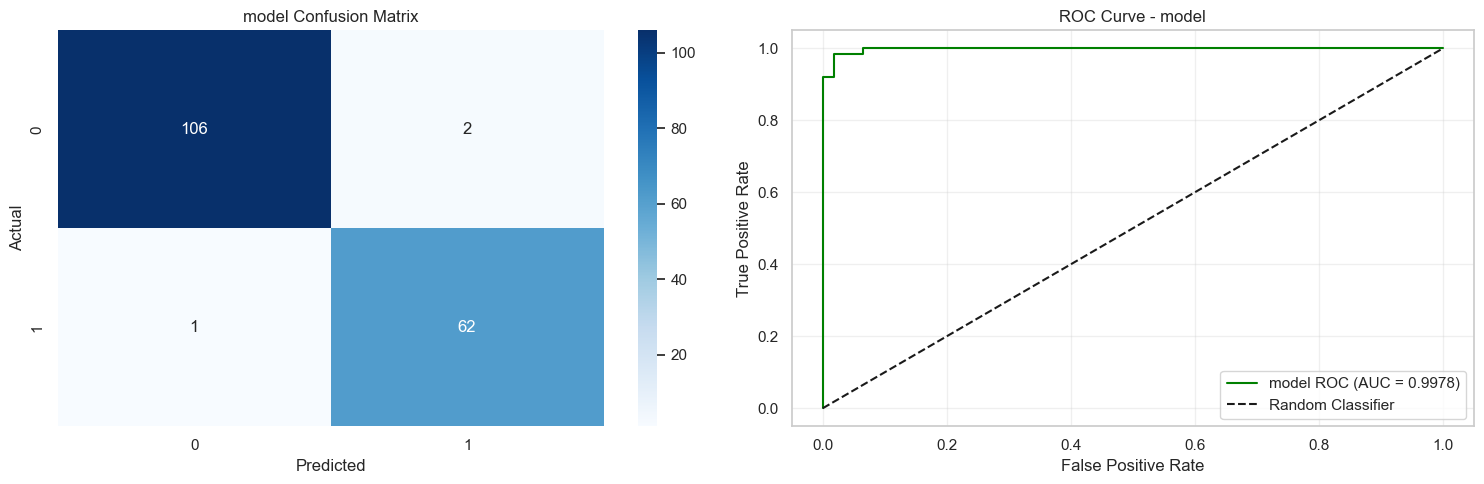


 Métricas de model:
AUC Score: 0.9978
Accuracy: 0.9825
F1-Score: 0.9764


In [34]:
plot_model_evaluation(y_test,y_pred_umbral,y_pred_prob,model_name='model')

In [35]:
recall = recall_score(y_test, y_pred_umbral)
print(f"Recall: {recall}")

Recall: 0.9841269841269841


We achieved a 75% reduction in false negatives.  
The model is sufficiently accurate with an AUC of 0.9978.

# 7. Analysis Conclusions

## Database Characteristics
- The database contains **37% of cases with malignant tumors** and 63% benign cases, showing a moderate imbalance toward benign cases.

## Variables Most Correlated with Diagnosis
The three variables that show the strongest correlations with the target variable are:

| Variable | Correlation |
|----------|-------------|
| `concave points_worst` | 0.793 |
| `perimeter_worst` | 0.782 |
| `concave points_mean` | 0.777 |

## 7.1 Patterns Identified in Malignant Tumors

### Morphological Characteristics
- **Concavities on the borders**: Patients with malignant tumors tend to present a higher number of concavities on the edges of the nucleus, indicating **more irregular borders**.  
  - Most frequent value of `concave points_mean`: **0.087**

- **Nucleus size**: The radius of the nucleus in patients with malignant tumors tends to be **significantly larger**.  
  - Most frequent value of `radius_mean`: **20.102**

### Relationship Between Variables
- There is a **strong correlation** (r = 0.82) between the radius of the nucleus and the concavities of its borders, suggesting that larger nuclei tend to have more irregular borders.

### Cohen’s Effect
- The probability that a person with a malignant tumor presents higher values in the variables `radius_mean` and `concave points_mean` compared to benign tumors is approximately **95%**.

---

## 7.2 Model

### Threshold Optimization
By adjusting classification thresholds, the following was achieved:

- **Increase in F1-Score**: +2%  
- **Increase in Recall**: +5%

> **Note**: Given the medical context of the model, this 2% increase in F1-Score is **significant**, as it represents an important improvement in the ability to correctly detect malignant cases, reducing both false positives and false negatives.
